In [1]:
from torchvision.models import vgg19
from torch.autograd import Variable
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [4]:
imsize = 512 
is_cuda = torch.cuda.is_available()

prep = transforms.Compose([transforms.Resize(imsize),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])

postpb = transforms.Compose([transforms.ToPILImage()])

def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [5]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(prep(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

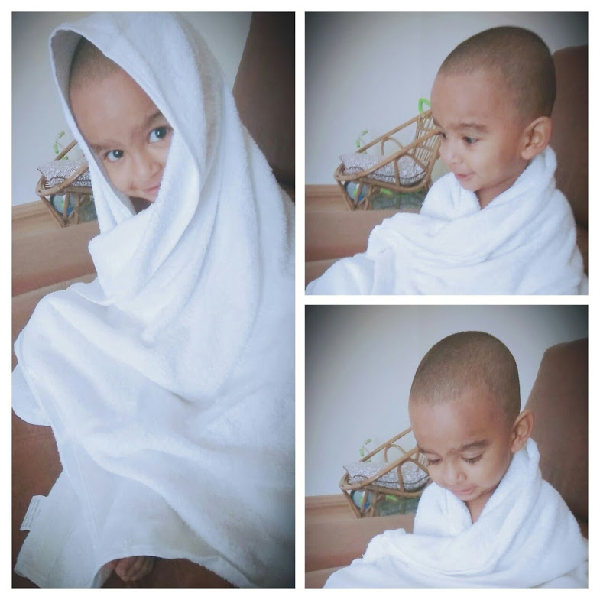

In [6]:
Image.open('images/amrut1.jpg').resize((600,600))

In [7]:
style_img = image_loader("images/vangogh_starry_night.jpg")
content_img = image_loader("images/amrut1.jpg")
vgg = vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad = False
if is_cuda:
    style_img = style_img.cuda()
    content_img = content_img.cuda()
    vgg = vgg.cuda()

opt_img = Variable(content_img.data.clone(),requires_grad=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/taeho/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:12<00:00, 45444265.09it/s]


In [8]:
style_layers = [1,6,11,20,25]
content_layers = [21]
loss_layers = style_layers + content_layers

In [9]:
class LayerActivations():
    features=[]
    
    def __init__(self,model,layer_nums):
        
        self.hooks = []
        for layer_num in layer_nums:
            self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))
    
    def hook_fn(self,module,input,output):
        self.features.append(output)

    
    def remove(self):
        for hook in self.hooks:
            hook.remove()
        

In [10]:
class GramMatrix(nn.Module):
    
    def forward(self,input):
        b,c,h,w = input.size()
        features = input.view(b,c,h*w)
        gram_matrix =  torch.bmm(features,features.transpose(1,2))
        gram_matrix.div_(h*w)
        return gram_matrix
        
class StyleLoss(nn.Module):
    
    def forward(self,inputs,targets):
        out = nn.MSELoss()(GramMatrix()(inputs),targets)
        return (out)
    

In [11]:
def extract_layers(layers,img,model=None):
    la = LayerActivations(model,layers)
    #Clearing the cache 
    la.features = []
    out = model(img)
    la.remove()
    return la.features


content_targets = extract_layers(content_layers,content_img,model=vgg)
content_targets = [t.detach() for t in content_targets]
style_targets = extract_layers(style_layers,style_img,model=vgg)
style_targets = [GramMatrix()(t).detach() for t in style_targets]
targets = style_targets + content_targets

In [12]:
loss_fns = [StyleLoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if is_cuda:
    loss_fns = [fn.cuda() for fn in loss_fns]

In [13]:
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

In [14]:
%%time
#run style transferu
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        out = extract_layers(loss_layers,opt_img,model=vgg)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data))

        return loss
    
    optimizer.step(closure)
    

Iteration: 50, loss: 25659.625000
Iteration: 100, loss: 13719.185547
Iteration: 150, loss: 11326.296875
Iteration: 200, loss: 10544.506836
Iteration: 250, loss: 10193.593750
Iteration: 300, loss: 9999.578125
Iteration: 350, loss: 9879.013672
Iteration: 400, loss: 9791.658203
Iteration: 450, loss: 9725.502930
Iteration: 500, loss: 9673.291016
CPU times: user 54 s, sys: 20 s, total: 1min 14s
Wall time: 1min 14s


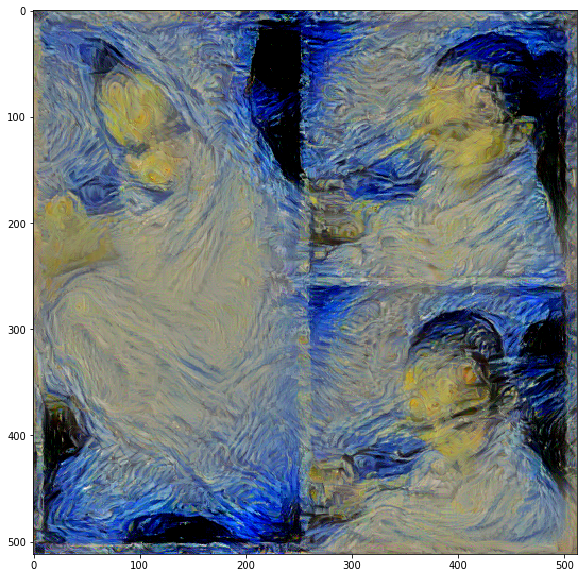

In [15]:
# 결과 출력
out_img_hr = postp(opt_img.data[0].cpu().squeeze())

imshow(out_img_hr)
gcf().set_size_inches(10,10)